<a href="https://colab.research.google.com/github/jbeen2/Today-I-Learned/blob/main/2021-1-MLstudy/ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2장. 간단한 분류 알고리즘 훈련

# 2.2 파이썬으로 퍼셉트론 학습 알고리즘 구현하기

## 2.2.1 객체 지향 퍼셉트론 API

In [1]:
import numpy as np


class Perceptron(object):
    """퍼셉트론 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    errors_ : list
      에포크마다 누적된 분류 오류

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta              # learning rate 
        self.n_iter = n_iter        # epoch 
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)                 # random state 설정 
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) # 가중치 초기화 
        self.errors_ = []                                               # error 저장 

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))         # learning rate * (target - predict)
                self.w_[1:] += update * xi                              # weight update 
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]                      # Wx + b 

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)                # 1 if x > 0, o.w -1 

In [2]:
v1 = np.array([1, 2, 3])
v2 = 0.5 * v1
np.arccos(v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))       # v1, v2 벡터 사이의 각도 

0.0

## 2.2.2 붓꽃 데이터셋에서 퍼셉트론 훈련하기

### 붓꽃 데이터셋 읽기

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

0    1    2    3               4
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

In [5]:
df[4].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: 4, dtype: int64

### 붓꽃 데이터 그래프 그리기

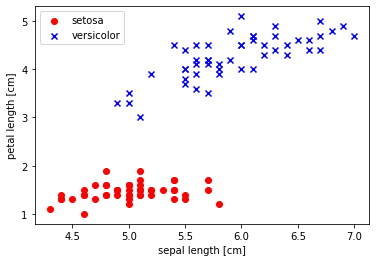

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# OvA (One-versus-All) : Setosa vs Others 
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)     # Setosa = -1 , Others (versicolor) : 1 

# 꽃받침 길이와 꽃잎 길이를 추출합니다
X = df.iloc[0:100, [0, 2]].values

# 산점도를 그립니다
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

### 퍼셉트론 모델 훈련하기

In [8]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')

plt.show()

### 결정 경계 그래프 함수

In [9]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)  # 예측값 
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

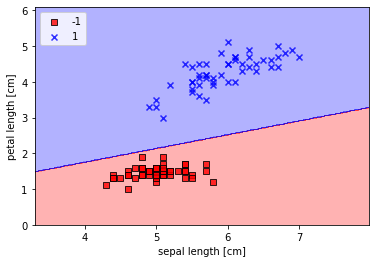

In [10]:
# update 된 그래프 
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

# 2.3 적응형 선형 뉴런과 학습의 수렴

## 2.3.2 파이썬으로 아달린 구현

In [12]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta                       # learning rate 
        self.n_iter = n_iter                 # epoch 
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)                     # random state 설정 
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])     # 가중치 초기화 
        self.cost_ = []                                                     # error 저장 

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)

            self.w_[1:] += self.eta * X.T.dot(errors)                       # learning rate * error 
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0                                  # 목적함수 : SSE
            self.cost_.append(cost)

        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]                          # Wx + b 

    def activation(self, X):
        """선형 활성화 계산"""                                                  # Activation Function 을 바꾸어 출력할 수 있습니다. 
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)   # Step Function 

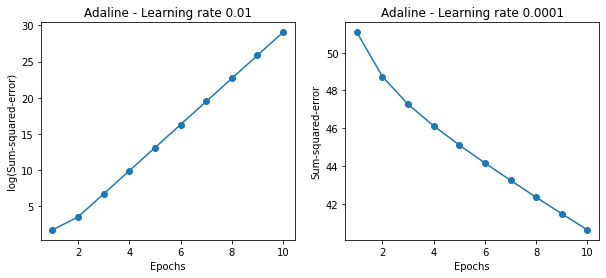

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# 오차가 epoch마다 점점 커집니다 = local minimum을 지나쳤기 때문! 
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

# error 값이 수렴하지 않습니다 = learning rate가 작아서, 충분하게 학습이 이루어지지 못했기 때문!
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

## 2.3.3 특성 스케일을 조정하여 경사 하강법 결과 향상

In [14]:
# Standardization : 특성을 표준화합니다.
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()    # (x - mean) / std 
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

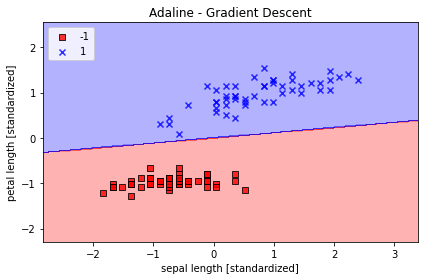

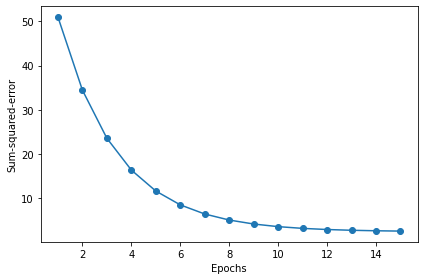

In [15]:
# 위의 동일한 learning rate에서의 결과보다 더욱 잘 학습이 된 것을 볼 수 있습니다. 
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.show()

## 2.3.4 대규모 머신 러닝과 확률적 경사 하강법

In [16]:
class AdalineSGD(object):
    """ADAptive LInear Neuron 분류기

    Parameters
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞습니다
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    Attributes
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta                          # learning rate 
        self.n_iter = n_iter                    # epoch 
        self.w_initialized = False              # Weight Initialization 여부 
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃 벡터

        반환값
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)                      # Random 초기값 설정 
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))   # error 저장 
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)                         # batch size 에서 error 계산 
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습합니다"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터를 섞습니다"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """랜덤한 작은 수로 가중치를 초기화합니다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트합니다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)

        self.w_[1:] += self.eta * xi.dot(error)                 # learning rate * error 
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2                                   # 목적함수 : SSE

        return cost
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X                                                # Activation Function 을 바꾸어 출력할 수 있습니다.

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)   # Step Function 

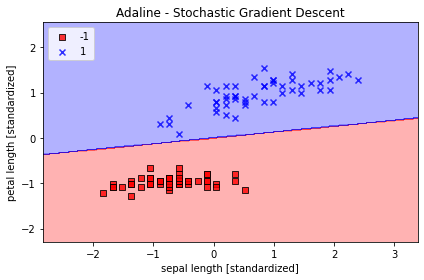

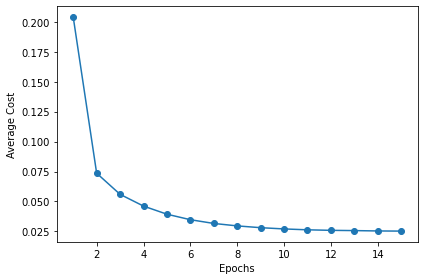

In [17]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()